In [7]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import copy
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.getcwd()

'/home/ubuntu/02-710/datasets/hemberg_human_pancreas'

## Data

In [12]:
input_matrix = pd.read_pickle('002_input_matrix.pkl')
input_matrix.shape

(3067, 8259)

In [20]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('tf_summaries/001/events.out.tfevents.1525079778.ip-172-31-11-126')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

{'images': [], 'audio': [], 'histograms': ['g_layer1/g_y1', 'g_layer2/g_y2', 'g_layer3/out', 'd_layer1/d_w1_bar', 'd_layer2/d_w2_bar', 'd_layer3/d_w3_bar', 'd_layer1/d_b1', 'd_layer2/d_b2', 'd_layer3/d_b3', 'd_layer1/d_y1', 'd_layer2/d_y2', 'd_layer3/D', 'd_layer1/d_w1_bar_1', 'd_layer2/d_w2_bar_1', 'd_layer3/d_w3_bar_1', 'd_layer1/d_b1_1', 'd_layer2/d_b2_1', 'd_layer3/d_b3_1', 'd_layer1/d_y1_1', 'd_layer2/d_y2_1', 'd_layer3/D_1', 'd_layer1/d_w1_bar_2', 'd_layer2/d_w2_bar_2', 'd_layer3/d_w3_bar_2', 'd_layer1/d_b1_2', 'd_layer2/d_b2_2', 'd_layer3/d_b3_2', 'd_layer1/d_y1_2', 'd_layer2/d_y2_2', 'd_layer3/D_2', 'layer1/g_w1', 'layer2/g_w2', 'layer3/g_w3', 'layer1/g_b1', 'layer2/g_b2', 'layer3/g_b3'], 'scalars': ['d_momentum', 'g_momentum', 'd_learning_rate', 'g_learning_rate', 'obj_d', 'obj_g'], 'distributions': ['g_layer1/g_y1', 'g_layer2/g_y2', 'g_layer3/out', 'd_layer1/d_w1_bar', 'd_layer2/d_w2_bar', 'd_layer3/d_w3_bar', 'd_layer1/d_b1', 'd_layer2/d_b2', 'd_layer3/d_b3', 'd_layer1/d_y1'

In [21]:
obj_d = event_acc.Scalars('obj_d')

In [22]:
len(obj_d)

10000

In [23]:
obj_d[0][2]

9.91378116607666

In [24]:
x = np.arange(1, len(obj_d) + 1)

In [25]:
obj_d_vals = [i[2] for i in obj_d]

In [26]:
obj_g = event_acc.Scalars('obj_g')
obj_g_vals = [i[2] for i in obj_g]

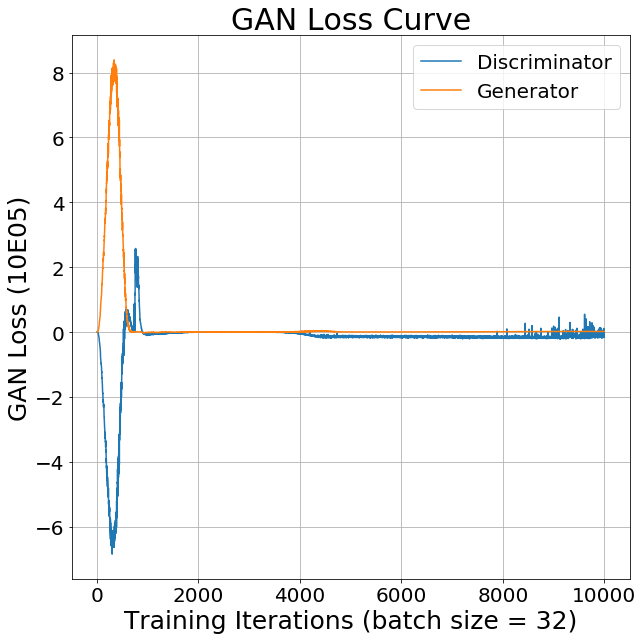

In [45]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x, np.asarray(obj_d_vals)/10000.0)
plt.plot(x, np.asarray(obj_g_vals)/10000.0)
plt.title('GAN Loss Curve',fontsize=30)
plt.xlabel('Training Iterations (batch size = 32)', fontsize=25)
plt.ylabel('GAN Loss (10E05)', fontsize=25)
lgnd = plt.legend(('Discriminator', 'Generator'), loc=1, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
lgnd.legendHandles[0]._sizes = [160]
lgnd.legendHandles[1]._sizes = [160]

plt.grid()

In [34]:
input_mat = pd.read_pickle('002_input_matrix.pkl').values

In [38]:
input_mat.shape

(3067, 8259)

In [132]:
trans_data = pd.read_csv('GOLDEN_OUTPUT_14000.csv', header=None)

In [133]:
trans_data.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,8.762668,5.130184,-0.845281,-0.463883,-0.122419,-0.853936,-0.690038,0.772122,0.939779,2.536633,...,-0.551932,2.370008,0.029892,0.815868,1.971893,0.980803,3.649934,-0.813588,2.317019,-0.273100
1,9.231832,5.659424,-1.045926,1.365880,-0.260163,-0.822996,1.369870,3.111070,-0.389397,2.146073,...,-0.739826,4.013675,1.480626,-0.174700,-0.055713,1.657829,6.870471,5.325482,2.669972,-0.188827
2,5.435523,1.916286,-0.693982,0.716512,-0.737967,-0.679535,-0.898120,2.331987,-0.036045,2.836336,...,-0.628728,0.670256,-0.421055,1.254115,-0.667883,-0.127070,6.869615,-0.146249,2.178842,-0.047831
3,4.787928,0.155153,-0.607060,0.043075,0.440522,1.053749,-0.121551,1.051065,1.113973,2.960031,...,1.094262,2.906886,0.037620,-0.305839,2.353570,0.591925,2.609986,1.188025,-0.182785,1.628202
4,6.986177,6.332902,-0.585039,-0.475264,-0.811609,-0.985325,-0.059473,0.999770,-0.264027,4.544907,...,-0.351004,5.288548,-0.468898,0.982284,0.412209,0.577526,6.812665,0.207183,-0.146040,-0.100033


In [134]:
trans_data = trans_data.values

In [135]:
trans_data.shape

(3067, 200)

In [127]:
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import operator

In [136]:
# tsne with 2 comps on the reduced data
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000)
tsne_components = tsne.fit_transform(trans_data)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 3067 samples in 0.014s...
[t-SNE] Computed neighbors for 3067 samples in 3.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3067
[t-SNE] Computed conditional probabilities for sample 2000 / 3067
[t-SNE] Computed conditional probabilities for sample 3000 / 3067
[t-SNE] Computed conditional probabilities for sample 3067 / 3067
[t-SNE] Mean sigma: 5.040185
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.057503
[t-SNE] Error after 1000 iterations: 2.441027


In [137]:
tsne.get_params()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'perplexity': 45,
 'random_state': None,
 'verbose': 1}

In [138]:
tsne_components.shape

(3067, 2)

In [139]:
tsne_components[0]

array([2.4884372, 3.0193374], dtype=float32)

In [140]:
dataset_dict = {'E-MTAB-5061': 1, 'GSE81608': 2}
cell_type_dict = {'alpha cell': 0, 
                    'beta cell': 1,
                    'delta cell': 2,
                    'gamma cell': 3}
dis_cond_dict = {'normal': 0 , 'type II diabetes mellitus' : 1}

In [141]:
pheno = pd.read_pickle('002_pheno.pkl').values.astype(int)

In [142]:
pheno.shape

(3067, 3)

In [143]:
tsne_components.shape

(3067, 2)

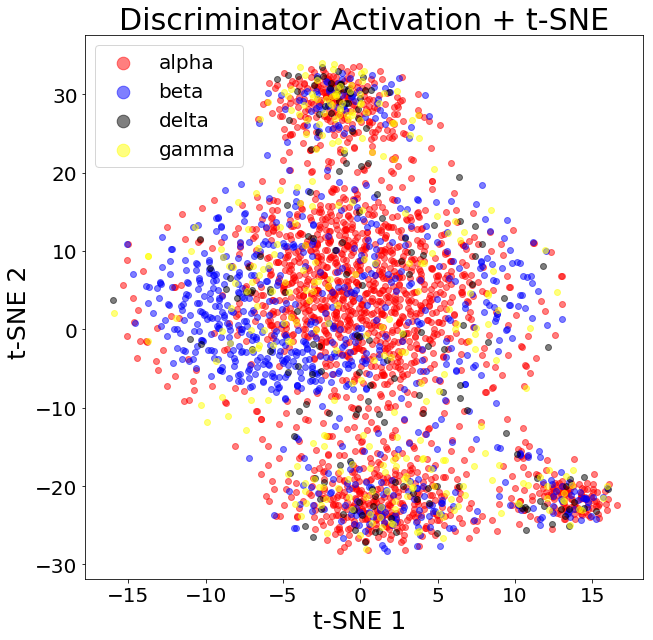

In [145]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
legend_set =  sorted(cell_type_dict.items(), key=operator.itemgetter(1))

colors = ['Red', 'Blue', 'Black', 'Yellow']
pheno_label = 'cell_type'

for k, col in zip(legend_set, colors):
    plot_idxs = np.where(pheno[:,0] == k[1])[0][:-1]
    plt.scatter(tsne_components[plot_idxs,0], tsne_components[plot_idxs, 1], c=col, alpha=0.5)


plt.xlabel('t-SNE 1 ',fontsize=25)
plt.ylabel('t-SNE 2 ',fontsize=25)


lgnd = plt.legend(('alpha', 'beta', 'delta', 'gamma'),loc=2, prop={'size': 20})


for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [160]

plt.title('Discriminator Activation + t-SNE',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.show()

In [ ]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
legend_set =  sorted(dataset_dict.items(), key=operator.itemgetter(1))

colors = ['Red', 'Blue']
pheno_label = 'dataset'

for k, col in zip(legend_set, colors):
    plot_idxs = np.where(pheno[:,2] == k[1])[0][:-1]
    plt.scatter(tsne_components[plot_idxs,0], tsne_components[plot_idxs, 1], c=col, alpha=0.5)


plt.xlabel('t-SNE 1 ',fontsize=25)
plt.ylabel('t-SNE 2 ',fontsize=25)


lgnd = plt.legend([i[0] for i in legend_set] ,loc=1, prop={'size': 20})


for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [160]

plt.title('Discriminator Activation + t-SNE',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.show()

In [151]:
tsne_gans = np.concatenate([tsne_components, pheno[:, 0].reshape((3067,1))], axis=1)

In [152]:
tsne_gans.shape

(3067, 3)

In [157]:
tsne_gans[0]

array([2.48843718, 3.01933742, 0.        ])

In [155]:
tsne_gans[-1]

array([6.76812124, 3.29358363, 0.        ])

In [156]:
pd.DataFrame(tsne_gans).to_csv("tsne_gans_with_pheno.csv", 
                               columns=None, 
                               header=False, 
                               index=False, 
                               index_label=None,
                               encoding="utf8")

In [88]:
tsne_components.shape

(3066, 2)

In [89]:
pheno.shape

(3067, 3)

In [92]:
type(tsne_components)

numpy.ndarray

In [93]:
type(pheno)

numpy.ndarray

In [94]:
pheno[:-1, 0].shape

(3066,)